In [1]:
import os
import wandb
import torch
import h5py
import numpy as np
import diffusion_pde as dpde
import matplotlib.pyplot as plt
#import seaborn as sns
from wandb.apis.public.runs import Runs, Run
from wandb.apis.public.artifacts import Artifacts, RunArtifacts, ArtifactFiles
#from hydra import initialize, compose
from omegaconf import OmegaConf
from copy import deepcopy
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
wandb.login()
API = wandb.Api()

wandb: Currently logged in as: philiphohwy (philiphohwy-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
wandb_cfg = OmegaConf.load("../conf/train.yaml").wandb

In [4]:
filters = {}#{"tags": "fine-tune"}

runs = Runs(
    client=API.client,
    entity=wandb_cfg.entity,
    project=wandb_cfg.project,
    filters=filters
)

In [5]:
for i, run in enumerate(runs):
    print(f"Index: {i} - Run ID: {run.id}, Name: {run.name}")

Index: 0 - Run ID: jjj9pelv, Name: heat-logt/joint/unet-v2


In [6]:
run_idx = 0
run_cfg = OmegaConf.create(runs[run_idx].config)

print(OmegaConf.to_yaml(run_cfg))

model:
  name: unet-v2
  emb_ch: 256
  obs_ch: 0
  base_ch: 64
  dropout: 0
  ch_mults:
  - 1
  - 2
  - 2
  noise_ch: 64
  sigma_data: 0.5
  n_res_blocks: 2
wandb:
  dir: /home/s204790/dynamical-pde-diffusion/logs
  name: None
  entity: philiphohwy-danmarks-tekniske-universitet-dtu
  project: dynamical-pde-diffusion-final
dataset:
  net:
    in_ch: 2
    label_ch: 2
  data:
    pde: heat
    name: heat_logt
    datapath: data/heat_logt.hdf5
  method: joint
  training:
    shuffle: true
    ema_decay: 0.999
    batch_size: 64
    ema_device: cpu
    ema_warmup: 20
    num_epochs: 1000
    val_percent: 0.1
    physics_loss: false
    val_interval: 10
    weight_decay: 0
    learning_rate: 0.0001
    gradient_clipping: 1
    physics_loss_coeff: 1
    checkpoint_interval: 50
    ema_update_interval: 1
  start_at_t0: false
  pretrained_path: null
  residual_estimation: null
run_name: heat-logt/joint/unet-v2



In [21]:
def get_model(run: Run, api: wandb.Api = API) -> str:
    model_path = Path(f"../pretrained_models/{run.id}/ema_model.pth").resolve()
    if not os.path.isfile(model_path):
        arts = RunArtifacts(client=api.client, run=run)
        pth = arts[0].download(root=f"../pretrained_models/{run.id}/")
    return model_path
    

#model_path = artifacts[0].download(root=f"../pretrained_models/{runs[run_idx].id}/")
model_path = get_model(runs[run_idx])
print(f"Model path: {model_path}")

wandb: Downloading large artifact 'heat-logt-joint-unet-v2:v1', 53.86MB. 2 files...
wandb:   2 of 2 files downloaded.  
Done. 00:00:00.3 (199.7MB/s)


Model path: /home/s204790/dynamical-pde-diffusion/pretrained_models/jjj9pelv/ema_model.pth


In [8]:
edm = dpde.utils.get_net_from_config(run_cfg)
edm.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [9]:
with h5py.File(dpde.utils.get_repo_root() / "data" / "heat_logt_validate.hdf5", "r") as f:
    data_A = f["A"][:]
    data_U = f["U"][:]
    data_labels = f["labels"][:]
    t_steps = f["t_steps"][:]
    attrs = dict(f.attrs)

dx = attrs["dx"]

In [11]:
for attr in attrs:
    print(f"{attr}: {attrs[attr]}")

Lx: 1.0
Ly: 1.0
N: 200
S: 64
T: 0.5
alpha_logrange: [-2.5  0.5]
description: 2D heat equation with linear Dirichlet BCs, pseudospectral interior DST with lifting. log-spaced time.
dx: 0.015873015873015872
dy: 0.015873015873015872
name: heat_logt_validate
steps: 100


In [12]:
with h5py.File(dpde.utils.get_repo_root() / "data" / "heat_logt.hdf5", "r") as f:
    attrs_train = dict(f.attrs)
for attr in attrs_train:
    print(f"{attr}: {attrs_train[attr]}")

Lx: 1.0
Ly: 1.0
N: 5000
S: 64
T: 0.5
alpha_logrange: [-2.5  0.5]
description: 2D heat equation with linear Dirichlet BCs, pseudospectral interior DST with lifting. log-spaced time.
dx: 0.015873015873015872
dy: 0.015873015873015872
name: heat_logt
steps: 64


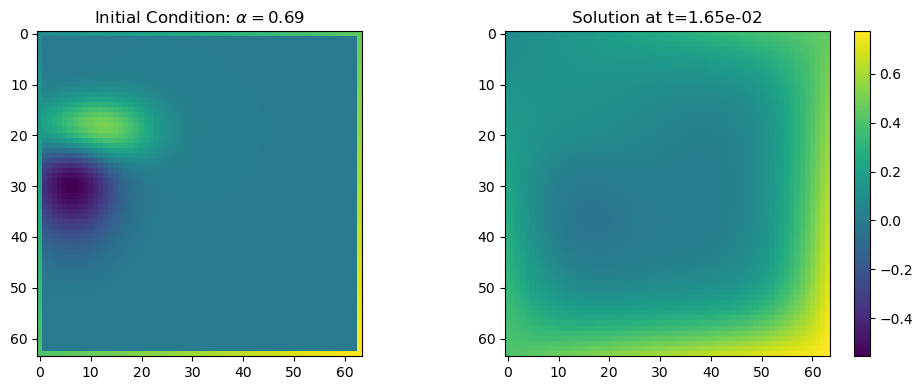

In [13]:
idx = 55     # which sample to visualize

t0_idx = 0    # initial time step
tf_idx = 60   # which time step to visualize

T = t_steps[tf_idx].item() - t_steps[t0_idx].item()     # time difference T = tf - t0
alpha = data_labels[idx, 0].item()                      # diffusivity parameter
a = data_U[idx, 0, :, :, t0_idx]  # (S, S)              # initial condition (at time t0)
u = data_U[idx, 0, :, :, tf_idx]  # (S, S)              # solution at time tf (after time t0 + T)

vmin, vmax = min(a.min(), u.min()), max(a.max(), u.max())
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im0 = axs[0].imshow(a, cmap="viridis", vmin=vmin, vmax=vmax)
axs[0].set_title(f"Initial Condition: $\\alpha={alpha:.2f}$")
im1 = axs[1].imshow(u, cmap="viridis", vmin=vmin, vmax=vmax)
axs[1].set_title(f"Solution at t={T:.2e}")
fig.colorbar(im1, ax=axs[1])
plt.tight_layout()
plt.show()

In [14]:
obs_a = torch.tensor(a)
obs_u = torch.tensor(u)
OBS = torch.stack([obs_a, obs_u], dim=0)

ch_a = 1 if run_cfg.dataset.method == "joint" else 0

sample_shape = (16, 2, 64, 64)

generator = torch.Generator().manual_seed(0)

interior_a = 1.0
interior_u = 0.0
boundary_a = 1.0
boundary_u = 0.0
same_boundary = True
boundary_obs_a = dpde.validation.random_boundary_mask(sample_shape[2], sample_shape[3], frac_obs=boundary_a)
if same_boundary:
    boundary_obs_u = boundary_obs_a[:]
else:
    boundary_obs_u = dpde.validation.random_boundary_mask(sample_shape[2], sample_shape[3], frac_obs=boundary_u)
interior_obs_a = dpde.validation.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=interior_a)
interior_obs_u = dpde.validation.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=interior_u)

mask_a = dpde.validation.combine_masks(boundary_obs_a, interior_obs_a)
mask_u = dpde.validation.combine_masks(boundary_obs_u, interior_obs_u)

In [15]:
sampler = dpde.sampling.EDMHeatSampler(
    net=edm,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    sample_shape=(64, 64),
    num_channels=2 if run_cfg.dataset.method == "joint" else 1,
    num_steps=50,
    sigma_min=0.002,
    sigma_max=80.0,
    rho=7.0,
)

In [16]:
class sampling_context:
    def __init__(self, sampler: dpde.sampling.EDMHeatSampler):
        self.sampler = sampler

    def __enter__(self):
        self.prev_fp32_prec = torch.backends.cudnn.conv.fp32_precision
        torch.backends.cudnn.conv.fp32_precision = 'tf32'
        self.sampler.net.eval()
        self.sampler.net.to(self.sampler.device)
        #return self.sampler
    
    def __exit__(self, exc_type, exc_value, traceback):
        torch.backends.cudnn.conv.fp32_precision = self.prev_fp32_prec
        self.sampler.net.to(torch.device("cpu"))
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

In [17]:
run_cfg.dataset.method

'joint'

Final total loss: 16.1237


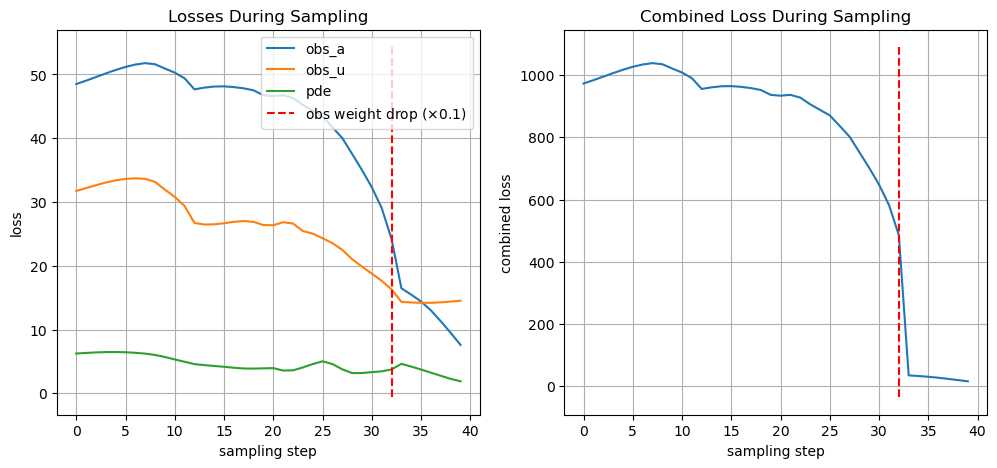

In [18]:
zeta_a = 20.0
zeta_u = 0.0
zeta_pde = 0.5

num_steps = 40

t_cond = torch.ones(sample_shape[0]) * T
alpha_cond = torch.ones_like(t_cond) * alpha
labels = torch.stack([t_cond, alpha_cond], dim=-1)

net_obs = obs_a.unsqueeze(0).unsqueeze(0).expand(sample_shape[0], -1, -1, -1) if run_cfg.dataset.method == "forward" else None

with sampling_context(sampler):
    samples, losses = sampler.sample_conditional(
        labels=labels,
        dx=dx,
        net_obs=net_obs,
        obs_a=obs_a,
        obs_u=obs_u,
        mask_a=mask_a,
        mask_u=mask_u,
        zeta_a=zeta_a,
        zeta_u=zeta_u,
        zeta_pde=zeta_pde,
        num_steps=num_steps,
        return_losses=True,
    )
    
print(f"Final total loss: {losses[-1, -1]:.4f}")

legend = ['obs_u', 'pde', 'obs weight drop ($\\times 0.1$)']
if run_cfg.dataset.method == "joint":
    legend = ['obs_a'] + legend

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :-1])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, -1])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(legend)
plt.show()

In [19]:
def plot_and_compute_metrics(samples, OBS, ch_idx):
    """
    samples: (B, C, H, W), C = 1 or 2
    OBS:     (2, H, W)      [0: IC, 1: ground truth]
    ch_idx:  which channel to PLOT when C=2
    """

    B, C, H, W = samples.shape

    if C == 1:
        OBS_for_pred = OBS[1].unsqueeze(0)   # (1, H, W)
        ch_plot = 0                          # only one channel in samples
    else:
        OBS_for_pred = OBS                   # (2, H, W)
        ch_plot = ch_idx                     # plot the user-chosen channel

    OBS_pred_exp = OBS_for_pred.unsqueeze(0)  # (1, C, H, W)
    errors = samples - OBS_pred_exp

    # ----- Denominator: data range per channel -----
    denom = OBS_for_pred.amax(dim=(1, 2)) - OBS_for_pred.amin(dim=(1, 2))
    denom = denom.view(C, 1, 1)  # (C, 1, 1) for broadcasting

    # ----- Pixel-wise statistics (per channel) -----
    pixel_MAE = errors.abs().mean(dim=0)                       # (C, H, W)
    pixel_rel_error = pixel_MAE / (denom + 1e-8) * 100.0       # (C, H, W)
    pixel_bias = errors.mean(dim=0)                            # (C, H, W)
    pixel_std = errors.std(dim=0) / (denom + 1e-8)             # (C, H, W)
    pixel_rel_std = samples.std(dim=0) / (denom + 1e-8)        # (C, H, W)

    # ----- Scalar summaries (averaged over channels & space) -----
    MAE = pixel_MAE.mean()
    rel_error = pixel_rel_error.mean()
    mean_std = pixel_std.mean()

    print("Summary Statistics:")
    print(f"  Mean Absolute Error (MAE):\t\t{MAE:.4f}")
    print(f"  Mean Relative Error:\t\t\t{rel_error:.2f}%")
    print(f"  Mean Error Standard Deviation:\t{mean_std:.4f}")

    # ----- Select the channel to PLOT stats for -----
    mae_plot = pixel_MAE[ch_plot]
    rel_mae_plot = pixel_rel_error[ch_plot]
    bias_plot = pixel_bias[ch_plot]
    std_plot = pixel_std[ch_plot]
    rel_std_plot = pixel_rel_std[ch_plot]

    plt_stat_data = [mae_plot, rel_mae_plot, bias_plot, std_plot, rel_std_plot]
    titles_stat = ["MAE", "Relative MAE (%)", "Bias", "Error Std Dev", "Sample Relative Std Dev"]

    # ----- Image plots -----
    idx0, idx1 = np.random.choice(B, size=2, replace=False)
    mean_pred = samples[:, ch_plot].mean(dim=0)
    sample0 = samples[idx0, ch_plot]
    sample1 = samples[idx1, ch_plot]

    plt_data = [OBS[0], OBS[1], mean_pred, sample0, sample1]
    titles = ["Initial Condition", "Ground Truth", "Mean Prediction", f"Sample {idx0}", f"Sample {idx1}"]

    if C == 1:
        obs_for_color = OBS[1]  # stats vs GT
    else:
        obs_for_color = OBS[ch_plot]

    vmin = min(obs_for_color.min(), samples[:, ch_plot].min())
    vmax = max(obs_for_color.max(), samples[:, ch_plot].max())

    fig, axs = plt.subplots(2, 5, figsize=(17, 7))

    # Top row: images
    for i, (data, title) in enumerate(zip(plt_data, titles)):
        im = axs[0, i].imshow(data.cpu(), cmap="viridis", vmin=vmin, vmax=vmax)
        axs[0, i].set_title(title)
        axs[0, i].axis('off')
        divider = make_axes_locatable(axs[0, i])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(im, cax=cax, orientation='vertical')

    # Bottom row: statistics maps for the selected channel
    for i, (data, title) in enumerate(zip(plt_stat_data, titles_stat)):
        im = axs[1, i].imshow(data.cpu(), cmap="inferno")
        axs[1, i].set_title(title)
        axs[1, i].axis('off')
        divider = make_axes_locatable(axs[1, i])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(im, cax=cax, orientation='vertical')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.18, hspace=0)
    plt.show()

Summary Statistics:
  Mean Absolute Error (MAE):		0.0516
  Mean Relative Error:			6.12%
  Mean Error Standard Deviation:	0.0676


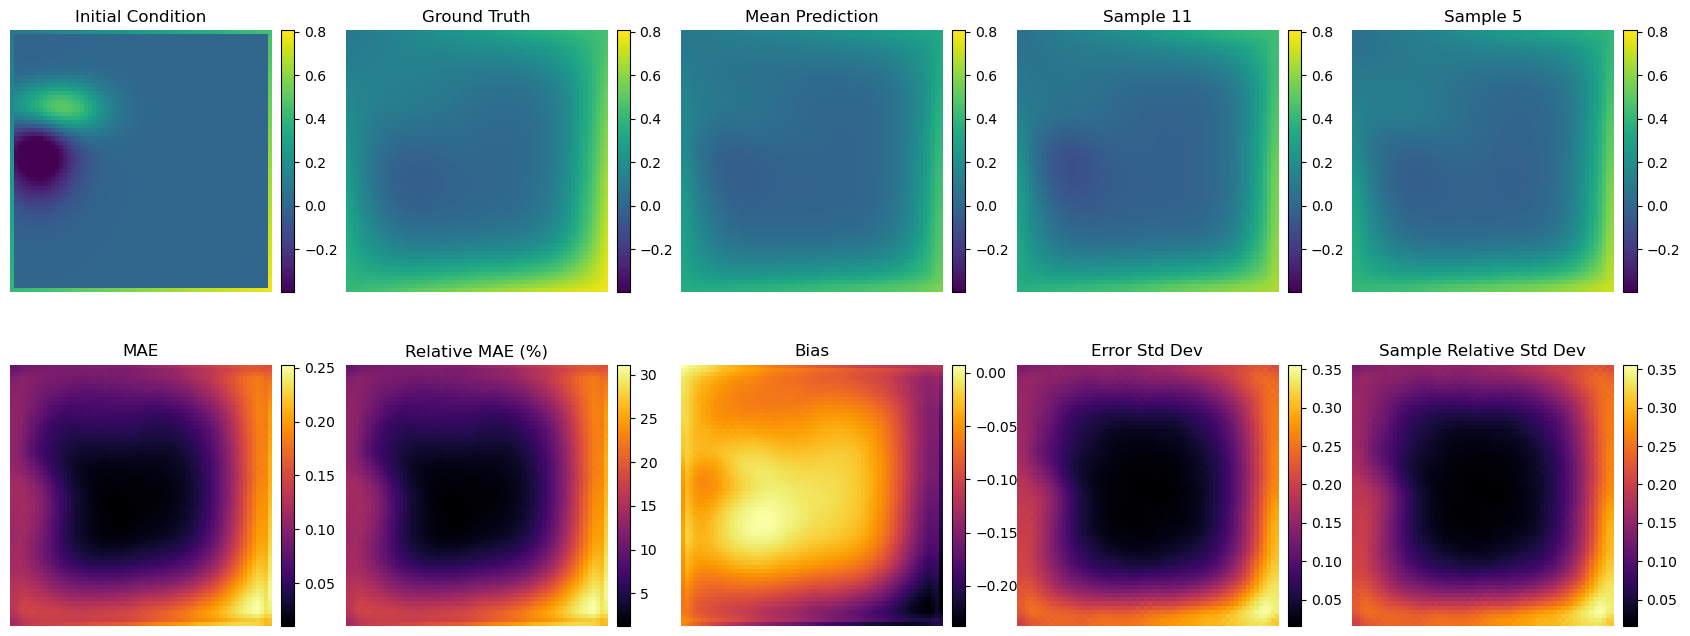

In [20]:
plot_and_compute_metrics(samples, OBS, 1)

Summary Statistics:
  Mean Absolute Error (MAE):		0.1348
  Mean Relative Error:			16.21%
  Mean Error Standard Deviation:	0.1644


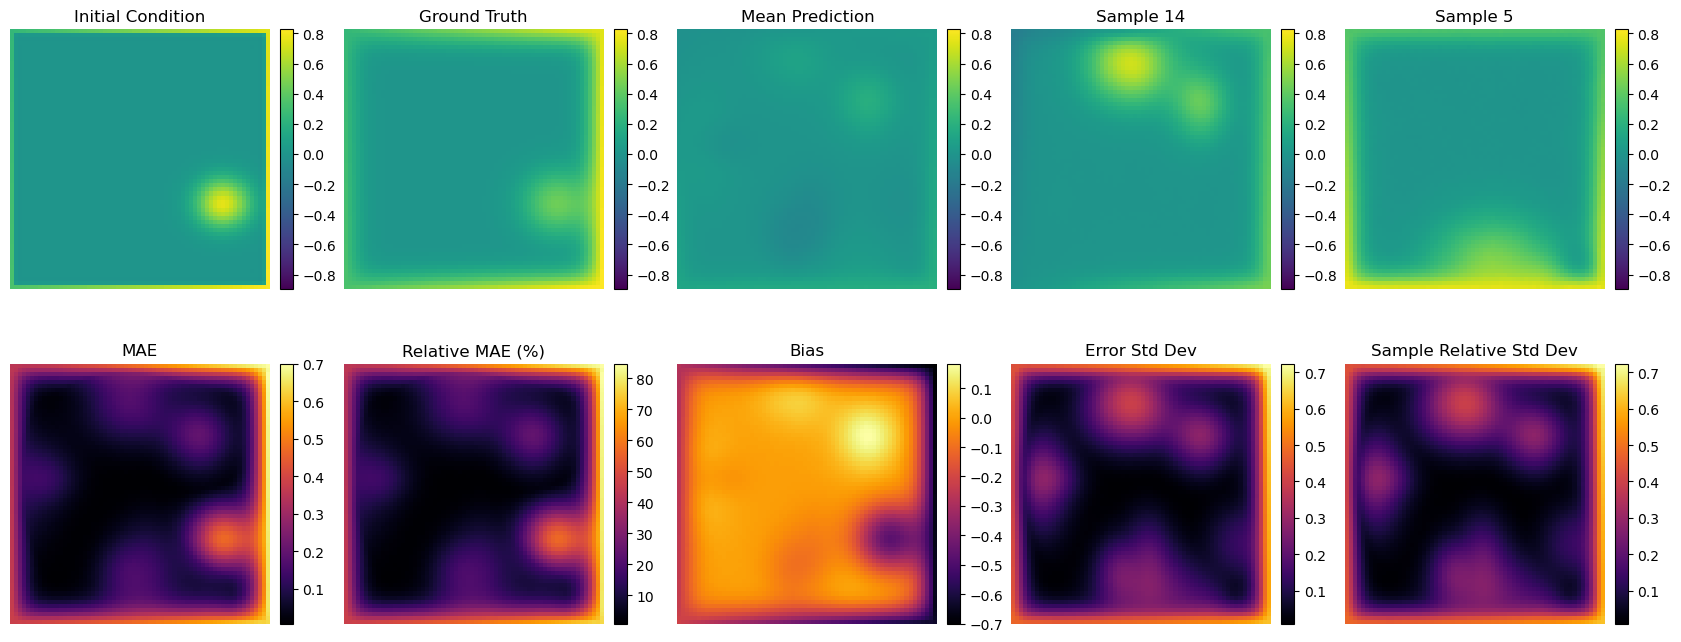

In [137]:
#edm.load_state_dict(torch.load(get_model(runs[-1]), weights_only=True))
with sampling_context(sampler):
    samples = sampler.sample(
        labels=labels,
        #net_obs=net_obs,
        num_steps=num_steps,
    )
plot_and_compute_metrics(samples, OBS, 1)

In [83]:
idx_to_compare = [0, 1]

Summary Statistics:
  Mean Absolute Error (MAE):		0.0404
  Mean Relative Error:			2.63%
  Mean Error Standard Deviation:	0.0353


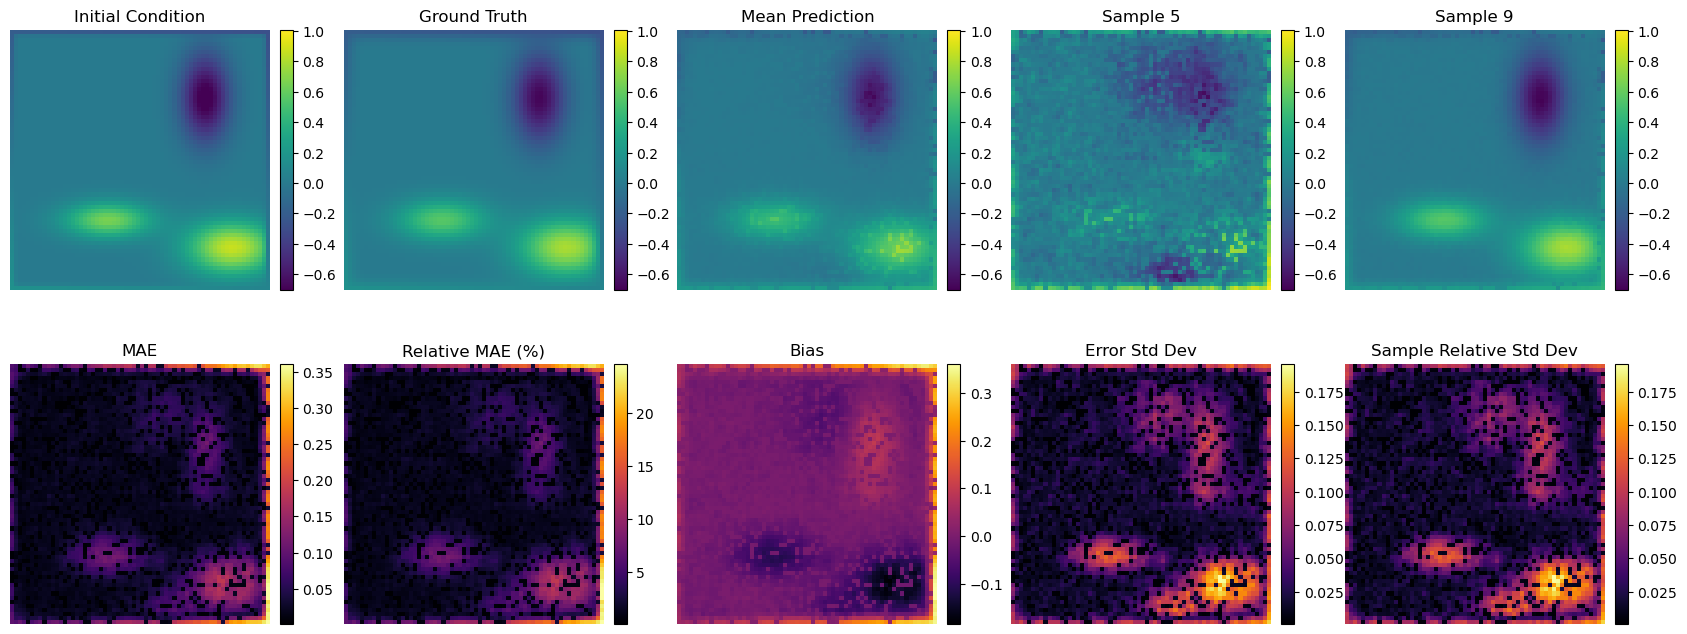

Summary Statistics:
  Mean Absolute Error (MAE):		0.0582
  Mean Relative Error:			3.80%
  Mean Error Standard Deviation:	0.0431


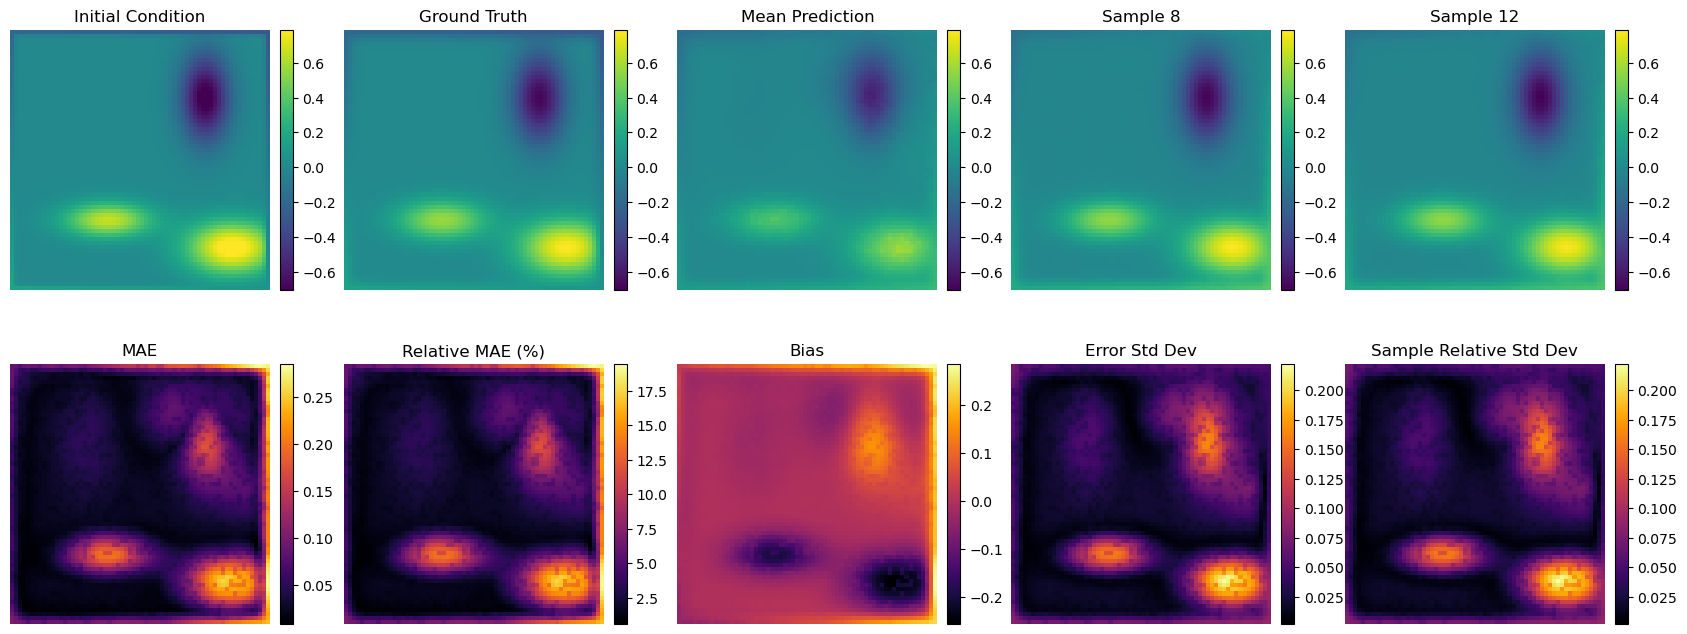

In [84]:
zeta_a = 20.0
zeta_u = 20.0
zeta_pde = 0.5

ch_idx = 1

for model_id in idx_to_compare:
    model_path = get_model(runs[model_id])
    edm.load_state_dict(torch.load(model_path, weights_only=True))
    with sampling_context(sampler):
        samples, losses = sampler.sample_conditional(
            labels=labels,
            dx=dx,
            net_obs=net_obs,
            obs_a=obs_a,
            obs_u=obs_u,
            mask_a=mask_a,
            mask_u=mask_u,
            zeta_a=zeta_a,
            zeta_u=zeta_u,
            zeta_pde=zeta_pde,
            num_steps=num_steps,
            return_losses=True,
        )
    plot_and_compute_metrics(samples, OBS, ch_idx)